# Basic analysis of replay stability and speed vs. network parameters

Here we ask whether replay stability and speed can be predicted from the parameters used to instantiate the networks. We stick to basic analyses: an SVM classifier for stability values, and linear regression for speed values.

In [1]:
%reset -f
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC

import aux
from db.d_models import LinRidgeTrial as T
from plot import set_font_size
from lin_ridge import viz

import PARAMETERS as P
from lin_ridge import search_global as C

In [2]:
trials = viz.select_trials(
    smln_id='smln_2',
    filt=[T.stability > 0.1, T.speed < 15],
    order_by='speed', lmt=10000)

In [3]:
trials.head()

,id,searcher_id,seed,area_h,area_w,ridge_y,p_inh,rho_pc,z_pc,l_pc,w_a_pc_pc,p_a_inh_pc,w_a_inh_pc,p_g_pc_inh,w_g_pc_inh,fr_ec,stability,angle,activity,speed
0,27322,27,3095,0.5,2.0,-0.125,0.104804,12828.369435,1.006843,0.021704,0.007826,0.084756,0.002716,0.007296,0.013900,36.035107,0.333333,0.325979,2.087849,8.160069
1,26794,27,8523,0.5,2.0,-0.125,0.105194,12806.913758,1.005002,0.021691,0.007991,0.084405,0.002576,0.007148,0.014050,36.041505,0.333333,1.768600,1.978643,8.225829
2,25821,27,7181,0.5,2.0,-0.125,0.102281,12747.201579,0.997270,0.022057,0.007869,0.083286,0.002471,0.008551,0.014321,36.072012,0.333333,-0.055167,2.073600,8.316506
3,27357,27,5346,0.5,2.0,-0.125,0.104665,12822.224511,1.007259,0.021771,0.007844,0.084675,0.002705,0.007308,0.013925,36.038532,0.333333,-0.377855,2.209356,8.467862
4,25446,25,1845,0.5,2.0,-0.125,0.102062,12870.691090,0.985335,0.022147,0.007729,0.083636,0.002512,0.009608,0.014411,36.058474,0.333333,-2.201022,2.267056,8.527369


In [4]:
trials.tail()

,id,searcher_id,seed,area_h,area_w,ridge_y,p_inh,rho_pc,z_pc,l_pc,w_a_pc_pc,p_a_inh_pc,w_a_inh_pc,p_g_pc_inh,w_g_pc_inh,fr_ec,stability,angle,activity,speed
2541,26483,28,5267,0.5,2.0,-0.125,0.103476,12808.920328,1.002681,0.022986,0.007863,0.082770,0.002523,0.008497,0.013796,36.097857,1.000000,0.186678,3.205559,12.858033
2542,26463,28,3777,0.5,2.0,-0.125,0.103283,12811.149352,1.001280,0.022960,0.007843,0.082809,0.002531,0.008508,0.013803,36.096338,0.333333,-0.331700,3.264094,12.920265
2543,24981,28,7776,0.5,2.0,-0.125,0.100300,12825.164842,1.003394,0.023066,0.008265,0.083802,0.002787,0.008052,0.014192,36.051279,0.333333,1.021259,3.219118,12.947869
2544,24850,26,5165,0.5,2.0,-0.125,0.101554,12753.934682,1.003869,0.022867,0.008331,0.082949,0.002838,0.008077,0.014581,36.059005,0.333333,0.009006,3.207512,13.016111
2545,24970,26,7297,0.5,2.0,-0.125,0.102069,12742.901030,1.003243,0.023016,0.008332,0.083145,0.002833,0.008085,0.014600,36.051342,0.333333,-0.515920,3.211200,13.160114


In [5]:
cols_x = [
    'p_inh', 'rho_pc', 'z_pc', 'l_pc', 'w_a_pc_pc',
    'p_a_inh_pc', 'w_a_inh_pc', 'p_g_pc_inh', 'w_g_pc_inh',
    'fr_ec'
]

x = trials[cols_x]
x = (x - x.mean()) / x.std()
x = x.as_matrix()
stability = np.round(trials['stability'].as_matrix() * 3).astype(int)
speed = trials['speed'].as_matrix()

### Stability prediction

Confusion matrix.
[[  70.  444.   55.]
 [  36.  813.  220.]
 [  16.  497.  395.]]


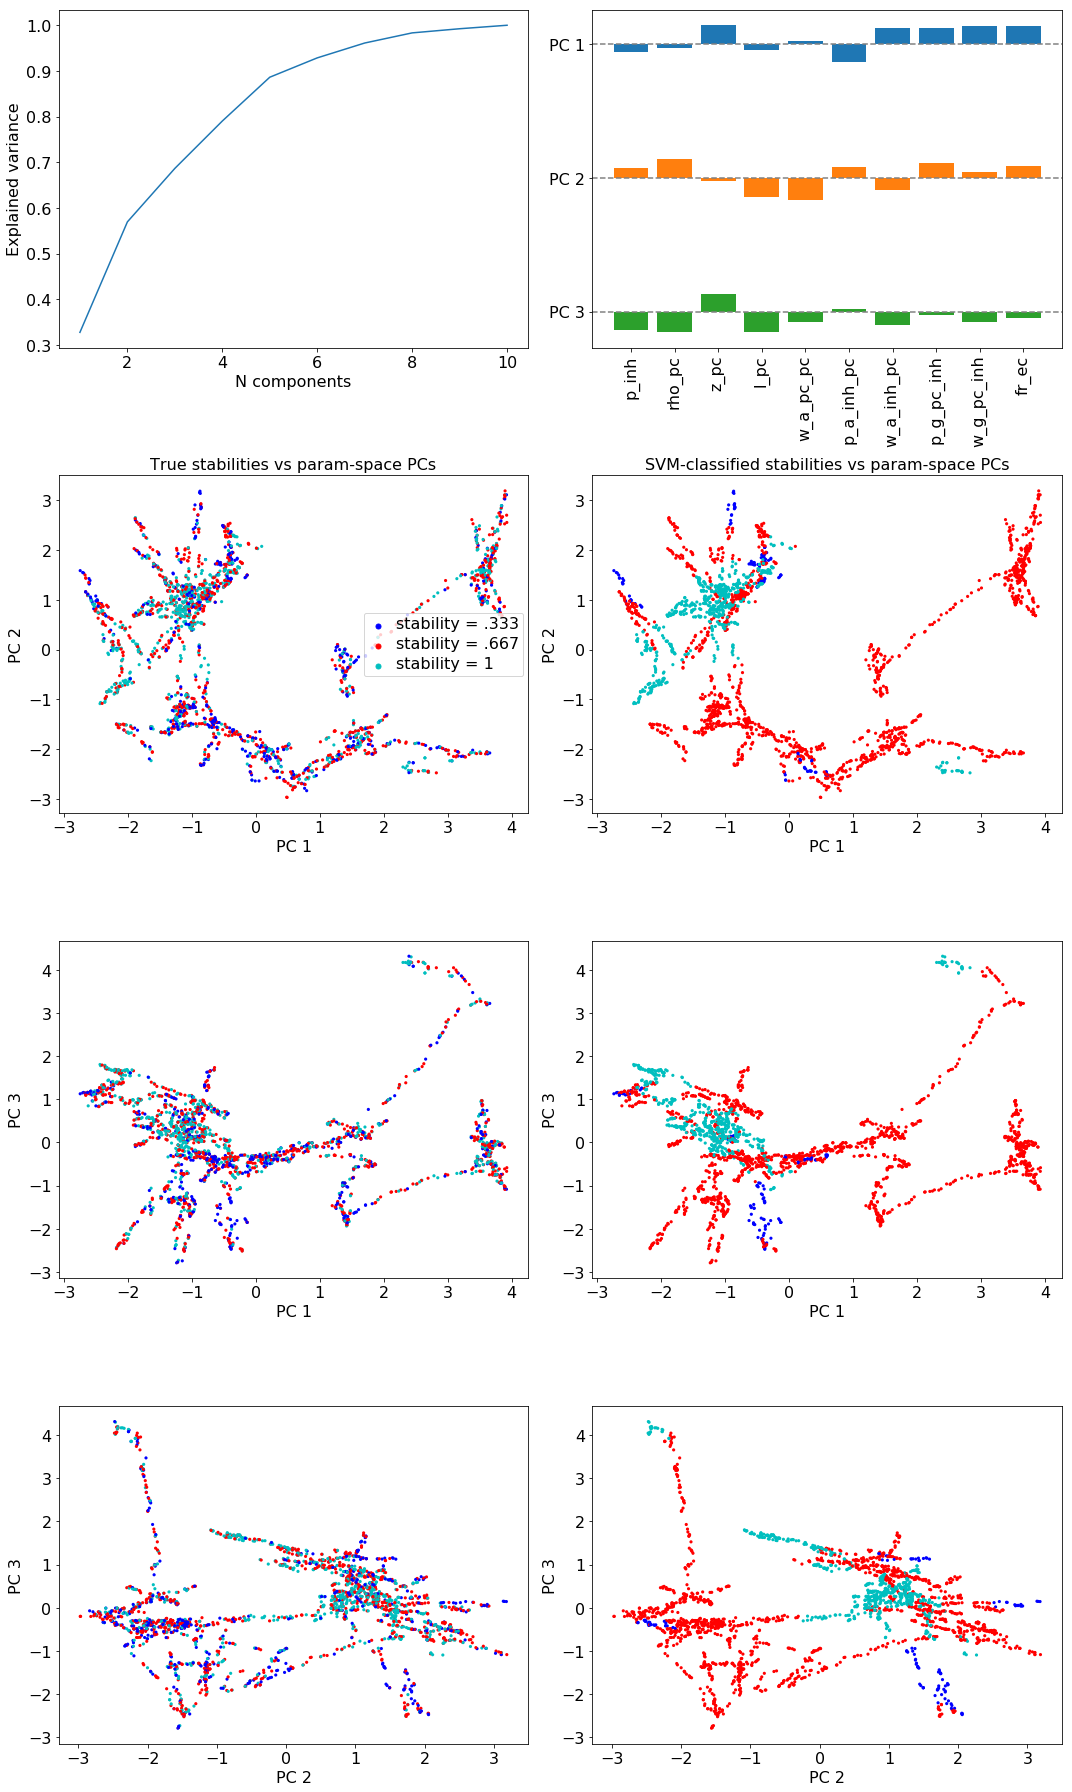

In [6]:
clf = SVC(C=2, kernel='rbf')
clf.fit(x, stability)
stability_ = clf.predict(x)

cfsn = confusion_matrix(stability, stability_).astype(float)

print('Confusion matrix.')
print(cfsn)

pca = PCA()
x_ = pca.fit_transform(x)

fig, axs = plt.subplots(4, 2, figsize=(15, 25), tight_layout=True)

c = np.repeat('', len(stability))
c[stability == 1] = 'b'
c[stability == 2] = 'r'
c[stability == 3] = 'c'

axs[0, 0].plot(np.arange(1, x_.shape[1] + 1), pca.explained_variance_ratio_.cumsum())
axs[0, 0].set_xlabel('N components')
axs[0, 0].set_ylabel('Explained variance')

x_bar = np.arange(len(cols_x))
offsets_bar = [0, -3, -6]

for ob_ctr, offset_bar in enumerate(offsets_bar):
    axs[0, 1].axhline(offset_bar, color='gray', ls='--')
    axs[0, 1].bar(x_bar, pca.components_[ob_ctr], bottom=offset_bar)
    
axs[0, 1].set_xticks(x_bar)
axs[0, 1].set_xticklabels(cols_x, rotation=90)
axs[0, 1].set_yticks(offsets_bar)
axs[0, 1].set_yticklabels(['PC 1', 'PC 2', 'PC 3'])

axs[1, 0].scatter(x_[:, 0], x_[:, 1], c=c, s=10, lw=0)
axs[1, 0].set_xlabel('PC 1')
axs[1, 0].set_ylabel('PC 2')

axs[2, 0].scatter(x_[:, 0], x_[:, 2], c=c, s=10, lw=0)
axs[2, 0].set_xlabel('PC 1')
axs[2, 0].set_ylabel('PC 3')

axs[3, 0].scatter(x_[:, 1], x_[:, 2], c=c, s=10, lw=0)
axs[3, 0].set_xlabel('PC 2')
axs[3, 0].set_ylabel('PC 3')

hs = []
hs.append(axs[0, 1].scatter([np.nan], [np.nan], color='b', label='stability = .333'))
hs.append(axs[0, 1].scatter([np.nan], [np.nan], color='r', label='stability = .667'))
hs.append(axs[0, 1].scatter([np.nan], [np.nan], color='c', label='stability = 1'))

axs[1, 0].legend(handles=hs, markerscale=5, loc='best')

c_ = np.repeat('', len(stability_))
c_[stability_ == 1] = 'b'
c_[stability_ == 2] = 'r'
c_[stability_ == 3] = 'c'

axs[1, 1].scatter(x_[:, 0], x_[:, 1], c=c_, s=10, lw=0)
axs[1, 1].set_xlabel('PC 1')
axs[1, 1].set_ylabel('PC 2')

axs[2, 1].scatter(x_[:, 0], x_[:, 2], c=c_, s=10, lw=0)
axs[2, 1].set_xlabel('PC 1')
axs[2, 1].set_ylabel('PC 3')

axs[3, 1].scatter(x_[:, 1], x_[:, 2], c=c_, s=10, lw=0)
axs[3, 1].set_xlabel('PC 2')
axs[3, 1].set_ylabel('PC 3')

axs[1, 0].set_title('True stabilities vs param-space PCs')
axs[1, 1].set_title('SVM-classified stabilities vs param-space PCs')

for ax in axs.flatten():
    set_font_size(ax, 16)

In examining trial locations and stabilities in PC space, clusters are rather hard to discern, although there certainly appear to be regions where full stability is more likely, and these are picked out by the SVM.

### Speed prediction

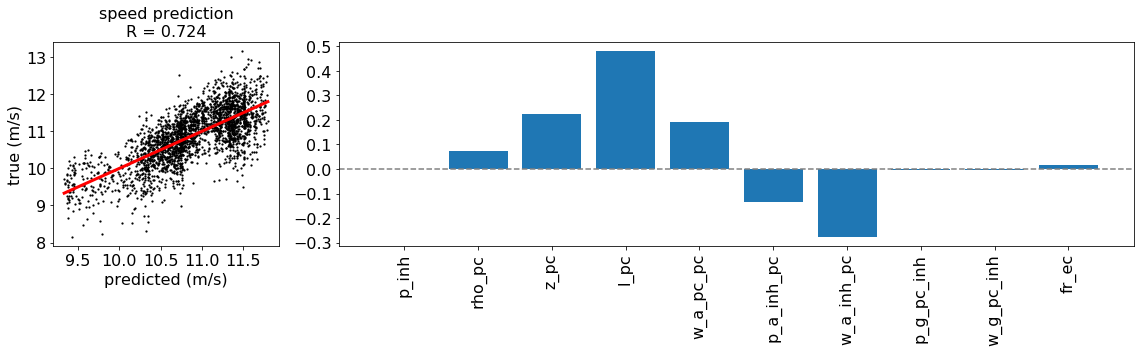

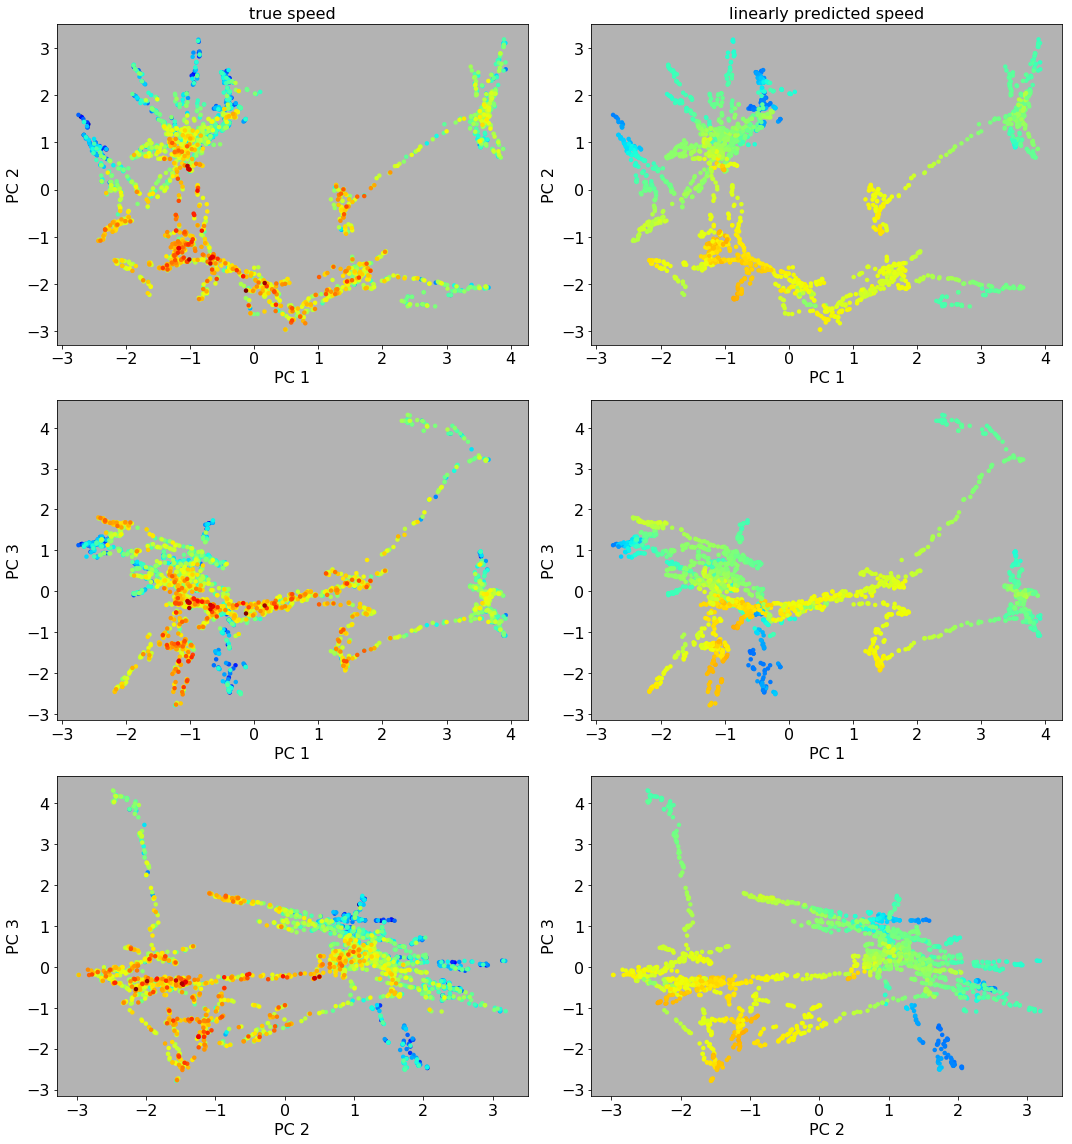

In [7]:
rgr = LinearRegression()
rgr.fit(x, speed)
speed_ = rgr.predict(x)
slp, icpt, r, p, _ = linregress(speed_, speed)

gs = gridspec.GridSpec(1, 4)

fig = plt.figure(figsize=(16, 5), tight_layout=True)

axs = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1:])]

# plot true vs predicted

axs[0].scatter(speed_, speed, s=5, c='k', lw=0)
x_line = np.array([speed_.min(), speed_.max()])
axs[0].plot(x_line, slp*x_line + icpt, color='r', lw=3)

axs[0].set_xlabel('predicted (m/s)')
axs[0].set_ylabel('true (m/s)')
axs[0].set_title('speed prediction\nR = {0:.3f}'.format(r))

# plot coefs
coefs = rgr.coef_
axs[1].bar(np.arange(len(coefs)), coefs, align='center')
axs[1].axhline(0, color='gray', ls='--')
axs[1].set_xticks(np.arange(len(coefs)))
axs[1].set_xticklabels(cols_x, rotation=90)

for ax in axs:
    set_font_size(ax, 16)
    
fig, axs = plt.subplots(3, 2, figsize=(15, 16), tight_layout=True)

vmin = min(speed.min(), speed_.min())
vmax = max(speed.max(), speed_.max())

axs[0, 0].scatter(x_[:, 0], x_[:, 1], c=speed, vmin=vmin, vmax=vmax, cmap='jet', s=20, lw=0)
axs[0, 0].set_xlabel('PC 1')
axs[0, 0].set_ylabel('PC 2')
axs[0, 0].set_title('true speed')

axs[1, 0].scatter(x_[:, 0], x_[:, 2], c=speed, vmin=vmin, vmax=vmax, cmap='jet', s=20, lw=0)
axs[1, 0].set_xlabel('PC 1')
axs[1, 0].set_ylabel('PC 3')

axs[2, 0].scatter(x_[:, 1], x_[:, 2], c=speed, vmin=vmin, vmax=vmax, cmap='jet', s=20, lw=0)
axs[2, 0].set_xlabel('PC 2')
axs[2, 0].set_ylabel('PC 3')

axs[0, 1].scatter(x_[:, 0], x_[:, 1], c=speed_, vmin=vmin, vmax=vmax, cmap='jet', s=20, lw=0)
axs[0, 1].set_xlabel('PC 1')
axs[0, 1].set_ylabel('PC 2')
axs[0, 1].set_title('linearly predicted speed')

axs[1, 1].scatter(x_[:, 0], x_[:, 2], c=speed_, vmin=vmin, vmax=vmax, cmap='jet', s=20, lw=0)
axs[1, 1].set_xlabel('PC 1')
axs[1, 1].set_ylabel('PC 3')

axs[2, 1].scatter(x_[:, 1], x_[:, 2], c=speed_, vmin=vmin, vmax=vmax, cmap='jet', s=20, lw=0)
axs[2, 1].set_xlabel('PC 2')
axs[2, 1].set_ylabel('PC 3')

for ax in axs.flatten():
    ax.set_facecolor((.7, .7, .7))
    set_font_size(ax, 16)

Here we see that propagation speed can be predicted fairly well from the network. Further, somewhat intuitively, it seems that the network parameters that increase propagation speed are Z_PC, L_PC, and W_A_PC_PC. That is, the more strongly and distantly the PCs are connected to one another, the faster activity propagates along the potentiated ridge. Furthermore, increased projections of the PC population onto the INH population seem to slow down propagation, consistent with the idea of inhibitory control.

The main thing that's missing from this analysis, however, is some sort of acknowledgement of gating. That is, continually moving along the best fit linear direction will not continually decrease the speed. Rather, there is certainly some value at which stability will drop to zero so that activity will no longer propagate. My intuition is that increasing the PC density, `rho_pc` will allow for lower speeds to propagate.